##Environment

In [1]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

import gym
from gym import spaces
import numpy as np

class CustomEnv(gym.Env):
    def __init__(self, start_collaboration=None):
        super(CustomEnv, self).__init__()

        # 0 = Explore
        # 1 = Retreat
        # 2 = Break or Initiate collaboration
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Discrete(9)

        # Allow user to decide starting collaboration status or randomize it
        self.start_collaboration = start_collaboration
        self.state = None

        self.terminal_states = [3, 4, 5, 6, 7, 8]

        self.prob_transition = {
            0: {  # Exploring, in collaboration
                0: [{"state": 6, "prob": 0.09, "reward": 100}, {"state": 0, "prob": 0.91, "reward": -2}],
                1: [{"state": 3, "prob": 1.0, "reward": 10}],
                2: [{"state": 2, "prob": 1.0, "reward": -1}]  # Break collaboration
            },
            1: {  # Exploring, never collaborated
                0: [{"state": 7, "prob": 0.01, "reward": 100}, {"state": 1, "prob": 0.99, "reward": -1}],
                1: [{"state": 4, "prob": 1.0, "reward": 10}],
                2: [{"state": 0, "prob": 1.0, "reward": -1}]  # Initiate collaboration
            },
            2: {  # Exploring, previously collaborated
                0: [{"state": 8, "prob": 0.05, "reward": 100}, {"state": 2, "prob": 0.95, "reward": -1}],
                1: [{"state": 5, "prob": 1.0, "reward": 10}],
                2: []  # Cannot re-initiate collaboration
            },
            3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}  # Terminal states
        }

        self.max_steps = 1000
        self.current_step = 0

    def step(self, action):
        assert self.action_space.contains(action), f"Invalid action: {action}"
        if self.state in self.terminal_states:
            return np.array(self.state, dtype=np.int32), 0, True, False, {}

        transitions = self.prob_transition.get(self.state, {}).get(action, None)
        if not transitions:
            return np.array(self.state, dtype=np.int32), -10, False, False, {"error": "Invalid action"}

        probs = [t["prob"] for t in transitions]
        choice = np.random.choice(len(transitions), p=probs)
        result = transitions[choice]

        self.state = result["state"]
        self.current_step += 1
        done = self.state in self.terminal_states or self.current_step >= self.max_steps
        return np.array(self.state, dtype=np.int32), result["reward"], done, False, {}

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        if self.start_collaboration is None:
            self.state = np.random.choice([0, 1])  # Start in or out of collaboration
        else:
            self.state = 0 if self.start_collaboration else 1
        self.current_step = 0
        return np.array(self.state, dtype=np.int32), {}

    def render(self):
        desc = {
            0: "Exploring, in collaboration",
            1: "Exploring, not in collaboration (never collaborated)",
            2: "Exploring, not in collaboration (previously collaborated)",
            3: "Retreated, in collaboration",
            4: "Retreated, not in collaboration (never collaborated)",
            5: "Retreated, not in collaboration (previously collaborated)",
            6: "AGI Discovered (collaboration)",
            7: "AGI Discovered (no collaboration)",
            8: "AGI Discovered (after breaking collaboration)"
        }
        print(f"Current State [{self.state}]: {desc.get(self.state, 'Unknown')}")


##Q Learning

In [2]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95,
                 exploration_rate=1.0, exploration_decay=0.995):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = 0.00001

        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))

        self.rewards_per_episode = []
        self.epsilons = []

        self.state_names = [
            "Exploring (collab)",
            "Exploring (never collab)",
            "Exploring (broke collab)",
            "Retreated (collab)",
            "Retreated (never collab)",
            "Retreated (broke collab)",
            "AGI (collab)",
            "AGI (no collab)",
            "AGI (broke collab)"
        ]
        self.action_names = ["Explore", "Retreat", "BreakCollab or Collab"]

    def choose_action(self, state):
        if random.random() < self.exploration_rate:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.discount_factor * np.max(self.q_table[next_state])
        self.q_table[state, action] += self.learning_rate * (target - self.q_table[state, action])

    def decay_exploration(self, episode):
        self.exploration_rate = max(
            self.min_exploration_rate, self.exploration_rate * self.exploration_decay
        )

    def train(self, num_episodes=5000):
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            total_reward = 0
            done = False

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.update_q_table(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

            self.decay_exploration(episode)
            self.rewards_per_episode.append(total_reward)
            self.epsilons.append(self.exploration_rate)

            if episode % 200 == 0:
                print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {self.exploration_rate:.4f}")
        return self.q_table

    def test(self, num_episodes=20):
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            trace = []

            while not done:
                action = np.argmax(self.q_table[state])
                trace.append((self.state_names[state], self.action_names[action]))
                next_state, reward, done, _, _ = self.env.step(action)
                total_reward += reward
                state = next_state

            trace.append((self.state_names[state], "END"))
            print(f"\nTest Episode {episode + 1}, Total Reward: {total_reward}")
            for step in trace:
                print(f"  State: {step[0]:<30} -> Action: {step[1]}")

    def plot_training_progress(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.rewards_per_episode)
        plt.title('Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')

        plt.subplot(1, 2, 2)
        plt.plot(self.epsilons)
        plt.title('Exploration Rate Decay')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')

        plt.tight_layout()
        plt.show()

    def visualize_q_table(self):
        q_df = pd.DataFrame(
            self.q_table,
            index=self.state_names,
            columns=self.action_names
        )

        plt.figure(figsize=(10, 6))
        sns.heatmap(q_df, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title('Q-Table Heatmap')
        plt.ylabel('State')
        plt.xlabel('Action')
        plt.tight_layout()
        plt.show()

        print("\nLearned Policy:")
        for i in range(len(self.state_names)):
            best_action = np.argmax(self.q_table[i])
            print(f"  {self.state_names[i]} -> {self.action_names[best_action]}")


##Run of Q Learning


===== Q-Learning =====
Episode 0, Reward: 7, Epsilon: 0.9950
Episode 200, Reward: -3, Epsilon: 0.3651
Episode 400, Reward: 4, Epsilon: 0.1340
Episode 600, Reward: 96, Epsilon: 0.0492
Episode 800, Reward: 97, Epsilon: 0.0180
Episode 1000, Reward: 94, Epsilon: 0.0066
Episode 1200, Reward: 89, Epsilon: 0.0024
Episode 1400, Reward: 90, Epsilon: 0.0009
Episode 1600, Reward: 79, Epsilon: 0.0003
Episode 1800, Reward: 100, Epsilon: 0.0001
Episode 2000, Reward: 89, Epsilon: 0.0000
Episode 2200, Reward: 80, Epsilon: 0.0000
Episode 2400, Reward: 47, Epsilon: 0.0000
Episode 2600, Reward: 85, Epsilon: 0.0000
Episode 2800, Reward: 54, Epsilon: 0.0000
Episode 3000, Reward: 98, Epsilon: 0.0000
Episode 3200, Reward: 81, Epsilon: 0.0000
Episode 3400, Reward: 88, Epsilon: 0.0000
Episode 3600, Reward: 98, Epsilon: 0.0000
Episode 3800, Reward: 89, Epsilon: 0.0000
Episode 4000, Reward: 99, Epsilon: 0.0000
Episode 4200, Reward: 79, Epsilon: 0.0000
Episode 4400, Reward: 96, Epsilon: 0.0000
Episode 4600, Rewa

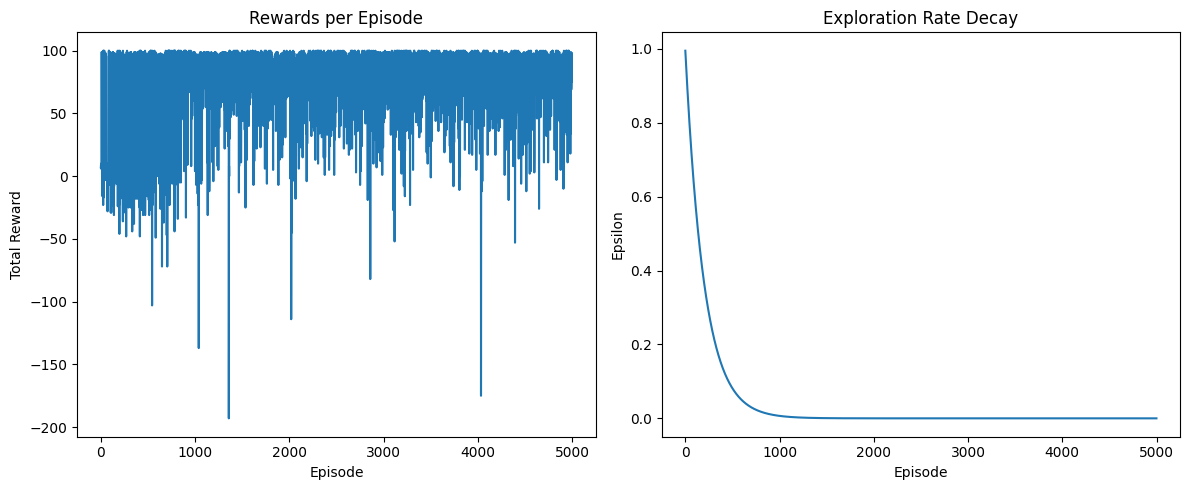

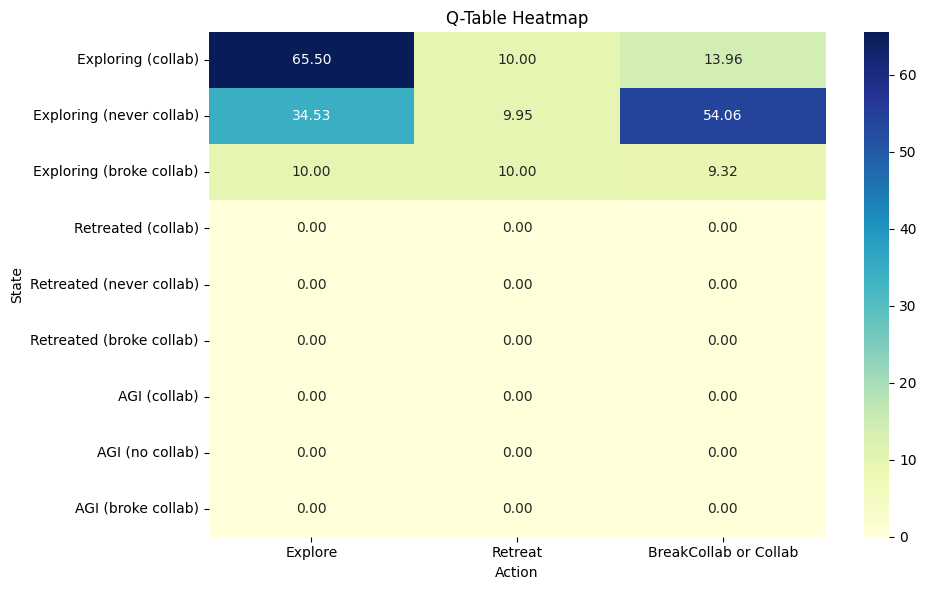


Learned Policy:
  Exploring (collab) -> Explore
  Exploring (never collab) -> BreakCollab or Collab
  Exploring (broke collab) -> Retreat
  Retreated (collab) -> Explore
  Retreated (never collab) -> Explore
  Retreated (broke collab) -> Explore
  AGI (collab) -> Explore
  AGI (no collab) -> Explore
  AGI (broke collab) -> Explore

Test Episode 1, Total Reward: 93
  State: Exploring (never collab)       -> Action: BreakCollab or Collab
  State: Exploring (collab)             -> Action: Explore
  State: Exploring (collab)             -> Action: Explore
  State: Exploring (collab)             -> Action: Explore
  State: Exploring (collab)             -> Action: Explore
  State: AGI (collab)                   -> Action: END

Test Episode 2, Total Reward: 85
  State: Exploring (never collab)       -> Action: BreakCollab or Collab
  State: Exploring (collab)             -> Action: Explore
  State: Exploring (collab)             -> Action: Explore
  State: Exploring (collab)             -> 

In [3]:
# 1. Q-Learning
print("\n===== Q-Learning =====")

# Initialize environment
env = CustomEnv()

# Initialize agent with parameters
q_agent = QLearningAgent(
    env,
    learning_rate=0.1,
    discount_factor=0.95,
    exploration_rate=1.0,
    exploration_decay=0.995
)

# Train the agent
q_table = q_agent.train(num_episodes=5000)

# Plot training progress
q_agent.plot_training_progress()

# Visualize Q-table
q_agent.visualize_q_table()

# Test the trained agent
q_agent.test(num_episodes=5)


## Value Iteration

In [4]:
class ValueIterationAgent:
    def __init__(self, env, discount_factor=0.95, theta=1e-6):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.V = np.zeros(env.observation_space.n)
        self.policy = np.zeros(env.observation_space.n, dtype=int)
        self.transitions = env.prob_transition
        self.terminal_states = env.terminal_states

    def run(self):
        while True:
            delta = 0
            for s in range(self.env.observation_space.n):
                if s in self.terminal_states:
                    continue
                action_values = []
                for a in range(self.env.action_space.n):
                    transitions = self.transitions.get(s, {}).get(a, [])
                    q_sa = sum(t['prob'] * (t['reward'] + self.discount_factor * self.V[t['state']])
                               for t in transitions)
                    action_values.append(q_sa)
                max_value = max(action_values)
                delta = max(delta, abs(max_value - self.V[s]))
                self.V[s] = max_value
            if delta < self.theta:
                break
        self.extract_policy()
        return self.V, self.policy

    def extract_policy(self):
        for s in range(self.env.observation_space.n):
            if s in self.terminal_states:
                continue
            action_values = []
            for a in range(self.env.action_space.n):
                transitions = self.transitions.get(s, {}).get(a, [])
                q_sa = sum(t['prob'] * (t['reward'] + self.discount_factor * self.V[t['state']])
                           for t in transitions)
                action_values.append(q_sa)
            self.policy[s] = int(np.argmax(action_values))

    def visualize(self):
        states = list(range(self.env.observation_space.n))
        plt.figure(figsize=(10, 4))
        plt.bar(states, self.V)
        plt.title("Value Function")
        plt.xlabel("State")
        plt.ylabel("Value")
        plt.show()

        print("\nOptimal Policy:")
        for s in states:
            print(f"State {s}: Take action {self.policy[s]}")


## Policy Iteration

In [5]:
class PolicyIterationAgent:
    def __init__(self, env, discount_factor=0.95, max_iterations=1000):
        self.env = env
        self.discount_factor = discount_factor
        self.policy = np.zeros(env.observation_space.n, dtype=int)
        self.V = np.zeros(env.observation_space.n)
        self.transitions = env.prob_transition
        self.terminal_states = env.terminal_states
        self.max_iterations = max_iterations

    def run(self):
        for _ in range(self.max_iterations):
            self.evaluate_policy()
            policy_stable = True
            for s in range(self.env.observation_space.n):
                if s in self.terminal_states:
                    continue
                old_action = self.policy[s]
                action_values = []
                for a in range(self.env.action_space.n):
                    transitions = self.transitions.get(s, {}).get(a, [])
                    q_sa = sum(t['prob'] * (t['reward'] + self.discount_factor * self.V[t['state']])
                               for t in transitions)
                    action_values.append(q_sa)
                best_action = int(np.argmax(action_values))
                self.policy[s] = best_action
                if best_action != old_action:
                    policy_stable = False
            if policy_stable:
                break
        return self.V, self.policy

    def evaluate_policy(self, theta=1e-6):
        while True:
            delta = 0
            for s in range(self.env.observation_space.n):
                if s in self.terminal_states:
                    continue
                a = self.policy[s]
                transitions = self.transitions.get(s, {}).get(a, [])
                v = sum(t['prob'] * (t['reward'] + self.discount_factor * self.V[t['state']])
                        for t in transitions)
                delta = max(delta, abs(v - self.V[s]))
                self.V[s] = v
            if delta < theta:
                break

    def visualize(self):
        states = list(range(self.env.observation_space.n))
        plt.figure(figsize=(10, 4))
        plt.bar(states, self.V)
        plt.title("Value Function (Policy Iteration)")
        plt.xlabel("State")
        plt.ylabel("Value")
        plt.show()

        print("\nOptimal Policy:")
        for s in states:
            print(f"State {s}: Take action {self.policy[s]}")


## Run of Value and Policy Iterations


===== Value Iteration =====


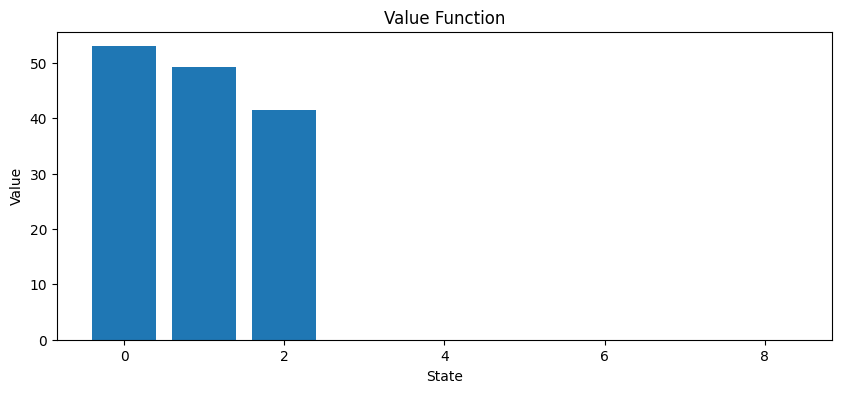


Optimal Policy:
State 0: Take action 0
State 1: Take action 2
State 2: Take action 0
State 3: Take action 0
State 4: Take action 0
State 5: Take action 0
State 6: Take action 0
State 7: Take action 0
State 8: Take action 0

===== Policy Iteration =====


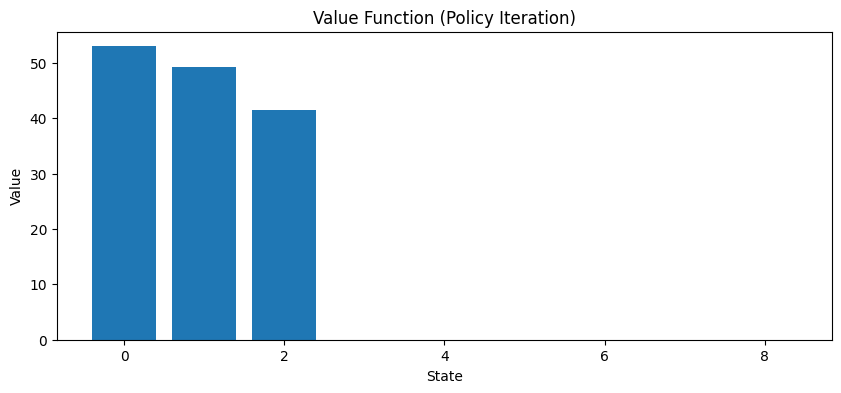


Optimal Policy:
State 0: Take action 0
State 1: Take action 2
State 2: Take action 0
State 3: Take action 0
State 4: Take action 0
State 5: Take action 0
State 6: Take action 0
State 7: Take action 0
State 8: Take action 0


In [6]:
env = CustomEnv()

# Value Iteration
print("\n===== Value Iteration =====")
vi_agent = ValueIterationAgent(env)
vi_values, vi_policy = vi_agent.run()
vi_agent.visualize()

# Policy Iteration
print("\n===== Policy Iteration =====")
pi_agent = PolicyIterationAgent(env)
pi_values, pi_policy = pi_agent.run()
pi_agent.visualize()
